# Simulation 3D of an inverted pendulum using a Mamdani controller with two inputs

***by Dr. Martin Montes Rivera***

Once installed all the required libraries also install blockdiag to update the block diagram.

For starting the movement of the pendulum press "q" when appears the simulation window

## REQUIRED IMPORTANT LIBRARIES FOR THE SIMULATION

In [1]:
import control
import os
import numpy as np
import time
import matplotlib.pyplot as plt
from IPython.display import Image, SVG, display
from pytictoc import TicToc
from vedo import *
from UPAFuzzySystems import fuzzy_universe, inference_system, fuzzy_controller
t = TicToc() 
t_count = TicToc() 

global prev_rot, vp, vp2, val, val2,X,textv,Theta,T

## Important Functions

In [2]:
def send_dataBlock(datablock):
    f= open("block_diagram","w+")
    f.write('blockdiag { '+datablock+' }')
    f.close() 
    os.system("blockdiag block_diagram -Tsvg")
    

In [3]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [4]:
def step_info(yout_val,t,settt=0.01):
    yout = moving_average(yout_val,15)
    maxval = np.amax(yout)
    minval = np.amin(yout)
    timerising = 0
    settlingtime = 0
    start_val = yout[0]
    end_val = yout[-1]
    overshoot = (maxval/yout[-1]-1)*100
    a = 0
    for i in range(len(yout)):
        if yout[i]==maxval:
            time_overshoot = t[i]
        if yout[i]>(yout[-1]*.90) and a==0 :
            timerising = t[i]
            a = 1
        if abs((yout[i]-yout[-1])/yout[-1])>=settt:
            settlingtime = t[i]
    if overshoot == 0:
        time_overshoot = 'N/A'
    step_infor_obt = [maxval,minval,start_val,end_val,timerising,overshoot,time_overshoot,settlingtime]
    print("Step Info Obtained:", "\nmaxval: ",step_infor_obt[0],"\nminval: ",step_infor_obt[1],"\nstart_val: ",step_infor_obt[2],"\nend_val: ",step_infor_obt[3],"\ntimerising: ",step_infor_obt[4],"\novershoot: ",step_infor_obt[5],"\ntime overshoot: ",step_infor_obt[6],"\nsettlingtime: ",step_infor_obt[7])
    return

## Defining the system

In [5]:
M = 2.4
m = 2.3e-1
L = 4e-1
J = 9.9e-2
b = 5.5e-2
g = 9.81
te = 50
ns = 5001


T=np.linspace(0,te,ns)
s = control.TransferFunction.s 
r = (M+m)*(m*L**2+J)-(m*L)**2
num = ((m*L)/r)*s
den =  s**3+((b*(m*L**2+J))/r)*s**2-(((M+m)*m*g*L)/r)*s-(b*m*g*L)/r
TF = num/den
XTF = (m*L**2+J)/(m*L)-g/s**2
XTFd = control.sample_system(XTF, T[1], method='zoh')
XSS = control.tf2ss(XTFd)
Xss = control.LinearIOSystem(
    XSS,
    inputs=1,
    outputs=1,
    states=2,
    name='position'
)



In [6]:
TF

TransferFunction(array([0.26384468, 0.        ]), array([ 1.        ,  0.02142017, -6.80727179, -0.14235739]))

## Defining the input of the system

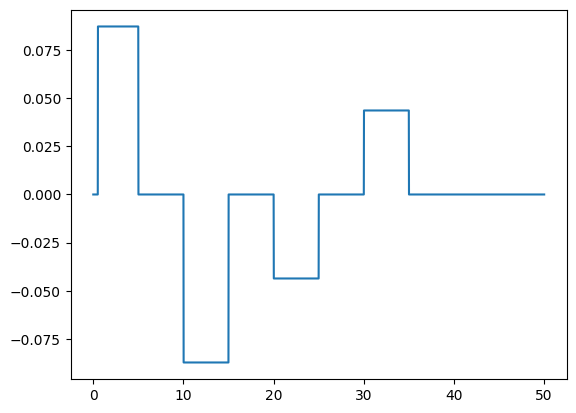

In [7]:
inlist = []
for tt in T:
    if (tt> 0.5 and tt<5):
        inlist.append(np.radians(5)*min((tt-0.5)/0.005,1)*1) 
    elif (tt> 10 and tt<15):
        inlist.append(np.radians(5)*min((tt-0.5)/0.005,1)*-1) 
    elif (tt> 20 and tt<25):
        inlist.append(np.radians(5)*min((tt-0.5)/0.005,1)*-0.5)
    elif (tt> 30 and tt<35):
        inlist.append(np.radians(5)*min((tt-0.5)/0.005,1)*0.5)
    else:
        inlist.append(0)
Input = np.array(inlist)
plt.plot(T,Input)


## Defining the System Rules

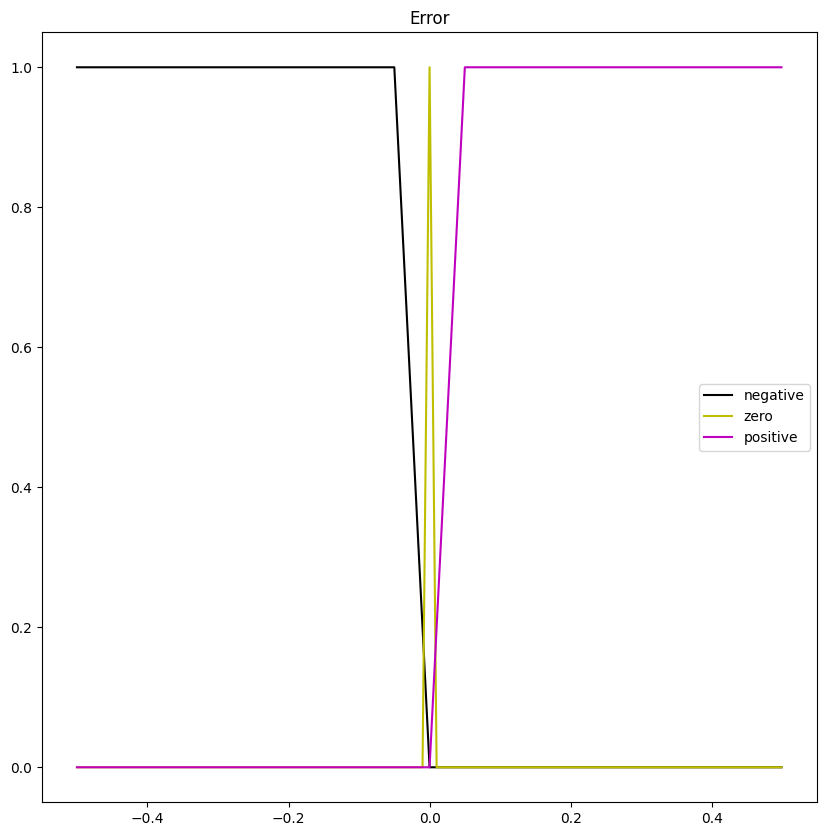

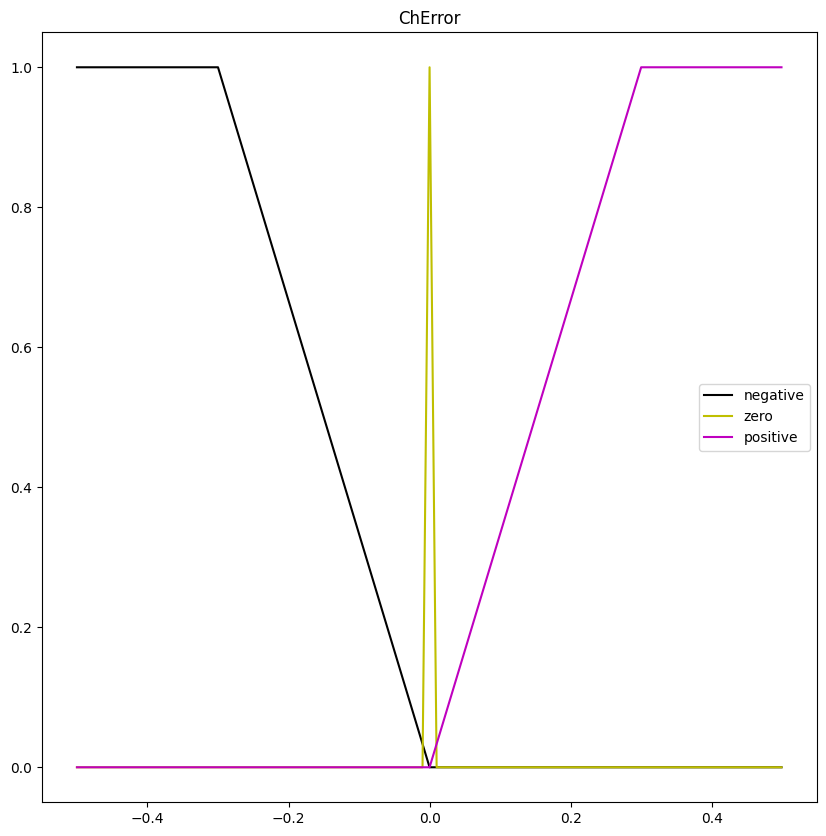

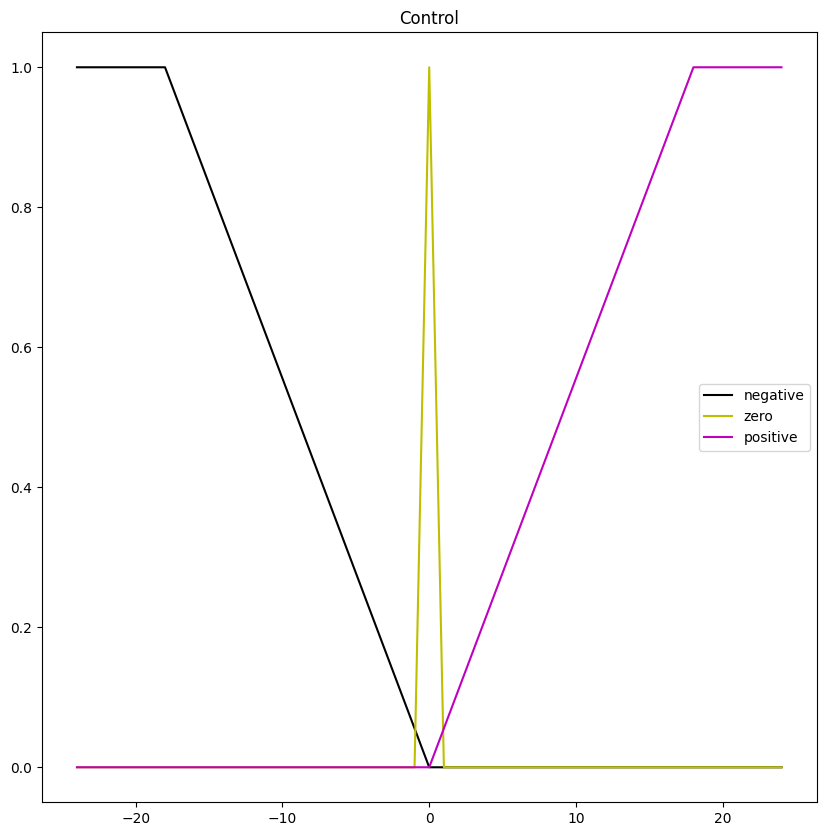

Elapsed time is 1.349070 seconds.


In [8]:
t.tic()
Error_universe = fuzzy_universe('Error', np.arange(-0.5,0.5,0.001), 'continuous')
Error_universe.add_fuzzyset('negative','trapmf',[-0.5,-0.5,-0.05,-0.0])
Error_universe.add_fuzzyset('zero','trimf',[-0.01,0,0.01])
Error_universe.add_fuzzyset('positive','trapmf',[0.0,0.05,0.5,0.5])
Error_universe.view_fuzzy()

ChError_universe = fuzzy_universe('ChError', np.arange(-0.5,0.5,0.001), 'continuous')
ChError_universe.add_fuzzyset('negative','trapmf',[-0.5,-0.5,-0.3,-0.0])
ChError_universe.add_fuzzyset('zero','trimf',[-0.01,0,0.01])
ChError_universe.add_fuzzyset('positive','trapmf',[0.0,0.3,0.5,0.5])
ChError_universe.view_fuzzy()

Control_universe = fuzzy_universe('Control', np.arange(-24,25,1), 'continuous')
Control_universe.add_fuzzyset('negative','trapmf',[-24,-24,-18,0])
Control_universe.add_fuzzyset('zero','trimf',[-0.001,0,0.001])
Control_universe.add_fuzzyset('positive','trapmf',[0,18,24,24])
Control_universe.view_fuzzy()


Mamdani1 = inference_system('Mamdani')
Mamdani1.add_premise(Error_universe)
Mamdani1.add_premise(ChError_universe)
Mamdani1.add_consequence(Control_universe)
Mamdani1.add_rule([['Error','negative'],['ChError','negative']],['and'],[['Control','negative']])
Mamdani1.add_rule([['Error','negative'],['ChError','positive']],['and'],[['Control','zero']])
Mamdani1.add_rule([['Error','zero']],[],[['Control','zero']])
Mamdani1.add_rule([['Error','positive'],['ChError','negative']],['and'],[['Control','zero']])
Mamdani1.add_rule([['Error','positive'],['ChError','positive']],['and'],[['Control','positive']])

Mamdani1.configure('Mamdani')
Mamdani1.build()
t.toc()
del Error_universe
del Control_universe

In [9]:
T[1]

0.01

(10, 10)
(10, 10)
(10, 10)


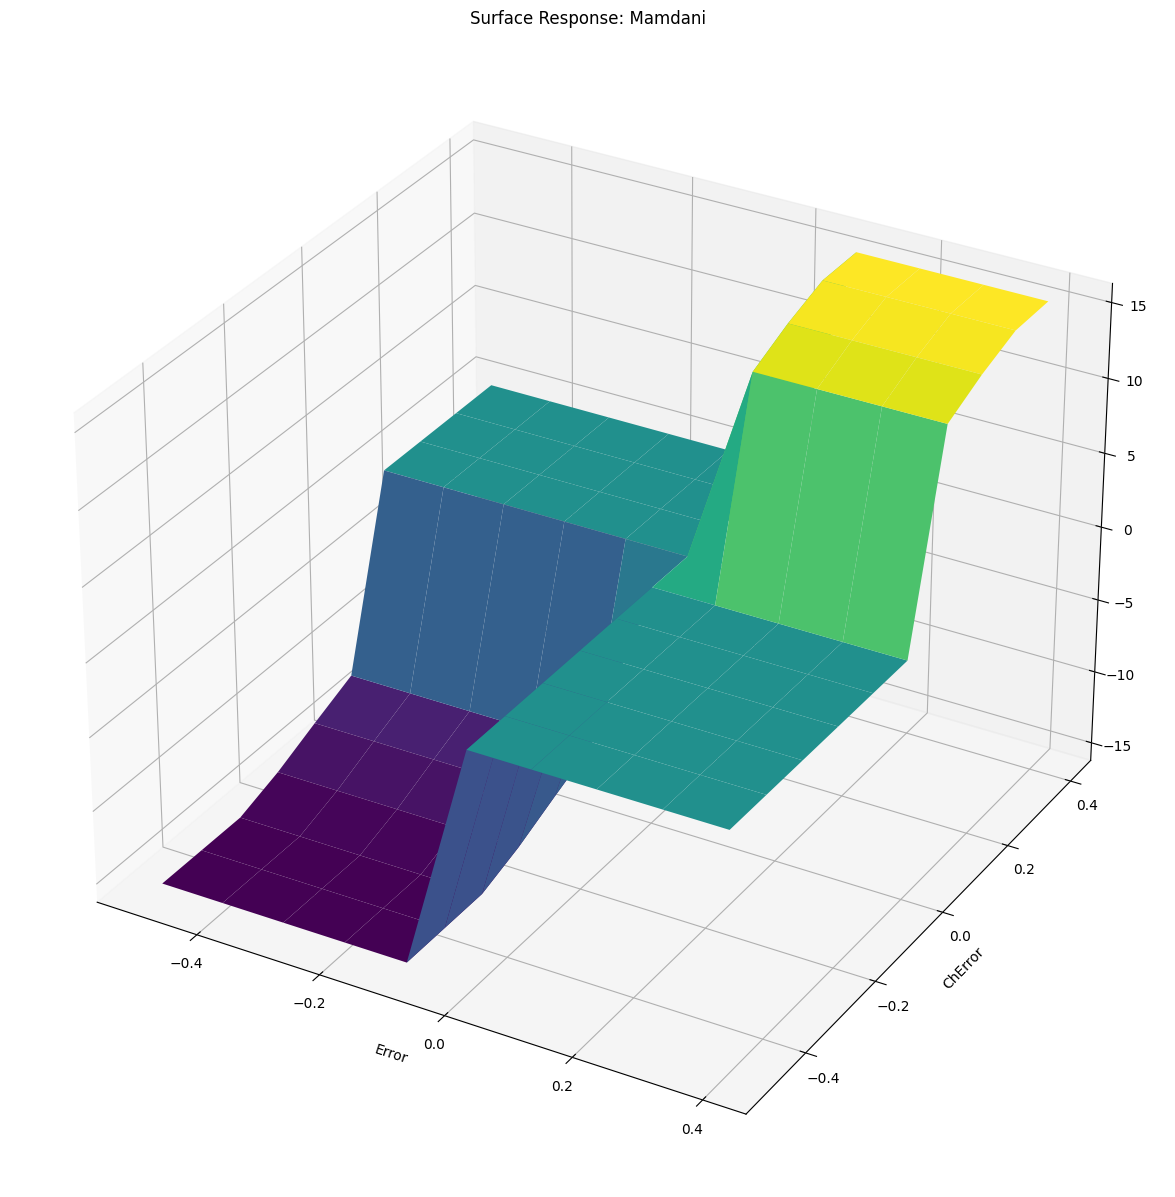

Elapsed time is 0.608784 seconds.


In [10]:
t.tic()
error_values = np.arange(-0.5,0.5,0.1)
cherror_values = np.arange(-0.5,0.5,0.1)
Mamdani1.surface_fuzzy_system([error_values,cherror_values])
t.toc()

## Defining the Fuzzy Controller

In [11]:
t.tic()
FuzzController = fuzzy_controller(Mamdani1,typec='Fuzzy2',tf=TF,DT = T[1])
FuzzController.build()
FuzzControllerBlock = FuzzController.get_controller()
FuzzSystemBlock = FuzzController.get_system()
t.toc()

Elapsed time is 0.008100 seconds.


In [12]:
t.tic()
T, Theta = control.input_output_response(FuzzSystemBlock,T,Input,X0= 0)
t.toc()
t.tic()
T, X = control.input_output_response(Xss,T,Theta,X0= 0)
t.toc()

Elapsed time is 51.061747 seconds.
Elapsed time is 0.266499 seconds.


Step Info Obtained: 
maxval:  0.10308156464980718 
minval:  -0.10082971178339323 
start_val:  -8.953758215208645e-21 
end_val:  -5.033074907897136e-05 
timerising:  0.0 
overshoot:  -204908.3259958386 
time overshoot:  3.75 
settlingtime:  49.85


(0.0, 50.0, -0.2, 0.2)

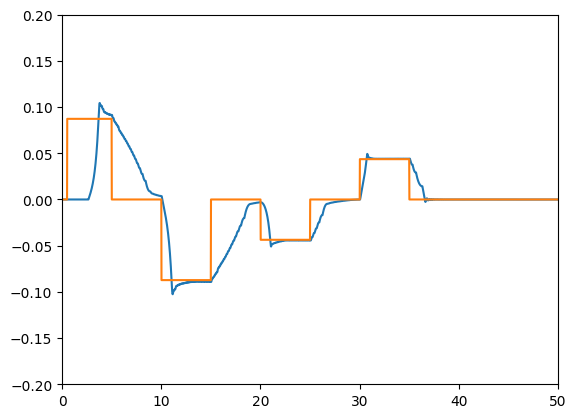

In [13]:
step_info(Theta,T)
plt.plot(T,Theta)
plt.plot(T,Input)
plt.axis([0, te, -0.2, 0.2])

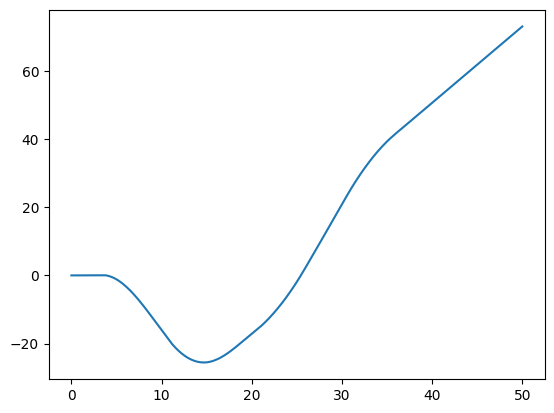

In [14]:
plt.plot(T,X)

## Showing Block Diagram

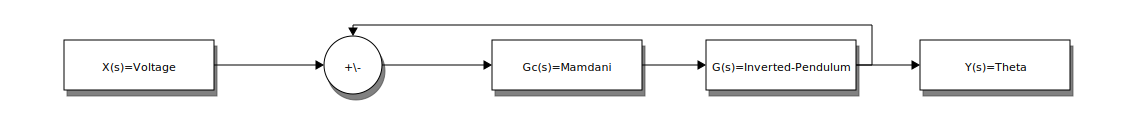

In [15]:
block = "node_width = 150;"
block += "node_height = 50;"
block += "Input [label = \"X(s)=Voltage\"];"
block += "Error [shape = \"circle\", label = \"+\\-\"];"
block += "Gc [label = \"Gc(s)=Mamdani\"];"
block += "Gs [label = \"G(s)=Inverted-Pendulum\"];"
block += "Output [label = \"Y(s)=Theta\"];  "
block += ' Input -> '
block += ' Error -> '
block += ' Gc -> '
block += ' Gs -> Error '
block += ' Gs -> Output ;'
send_dataBlock(block)
display(SVG('block_diagram.svg'))

## 3D Simulation  of the Motor

In [22]:
settings.allow_interaction = False
settings.default_backend = 'qt'
vp = Plotter(axes=4,interactive=False, bg ='k',bg2='w')

world = Box([0,0,0], 1, 1, 1,c='r').wireframe()
b = Box([0,0.25,0], 200, 1, 1).wireframe()
axs = Axes(b,          # build axes for object sph
           xtitle="x axis",
           ytitle="y axis",
           ztitle="z axis",
           xyframe_color='red3',
           yzframe_color='green3',
           zxframe_color='blue3',
           xhighlight_zero=True,
           xhighlight_zero_color='red',
           xlabel_color='c',
           xlabel_size=0.001,
           xlabel_offset = -5,
           axes_linewidth= 10,
           xtick_length = 0.008,
           xtick_thickness = 0.0005,
           number_of_divisions = 200
)
BaseMotor = Box([0,0,0],0.5, 0.3, 0.3, c="y",alpha = 0.8)
wheel1 = Cylinder(pos=(-0.18,-0.15,0.15),r=0.08,height=0.02,c='r')
wheel2 = Cylinder(pos=(0.18,-0.15,0.15),r=0.08,height=0.02,c='r')
wheel3 = Cylinder(pos=(0.18,-0.15,-0.15),r=0.08,height=0.02,c='r')
wheel4 = Cylinder(pos=(-0.18,-0.15,-0.15),r=0.08,height=0.02,c='r')
Bar1 = Box([0,0.35,0],0.03, 0.4, 0.03, c="r")
Thetaval = Latex(r'\theta = ',s=0.3,c="darkblue",bg='',alpha=1,usetex=False).pos(-0.25,0.42,0.3)
val =Text3D('0.00°',s=0.06,c="darkblue",alpha =0.9, italic = True ,depth = 0.01).pos(0.0,0.48,0.3)
val2 =Text3D('t = '+str(np.round(0/ns,2))+'s',s=0.06,c="darkblue",alpha =0.9, italic = True ,depth = 0.01).pos(-0.2,0.58,0.3)
vp += world
vp += BaseMotor
vp += wheel1
vp += wheel2
vp += wheel3
vp += wheel4
vp += Bar1
vp += Thetaval
vp += val
vp += val2
vp += axs
textv = "Inverted Pendulum\nDr. Martín Montes Rivera\nt="+\
    str(np.round(0,2))+\
    "\nTheta="+str(np.round(0,2))+"º"+\
    "\nTheta_ref="+str(np.round(0,2))+"º"+\
    "\nX="+str(np.round(0,2))+"m"
vp += textv
vp.show(camera ={'pos':(X[0],0,4),'focalPoint':(X[0],0,0)}).interactive()

prev_rot = 0.0
pb = ProgressBar(0, ns, 10, c="b")
t=0
V=0
for tt in pb.range():
    t_count.tic()
    t = int(tt)
    if t>0:
        V= abs((((X[t]-X[t-1])/0.001)/1000)*3600)
    current_rot = np.degrees(Theta[t])
    world.pos(X[t],0,0)
    BaseMotor.pos(X[t],0,0)
    Bar1.pos(X[t],0.35,0)
    wheel1.pos(X[t]+-0.18,-0.15,0.15)
    wheel2.pos(X[t]+0.18,-0.15,0.15)
    wheel3.pos(X[t]+0.18,-0.15,-0.15)
    wheel4.pos(X[t]+-0.18,-0.15,-0.15)
    Thetaval.pos(X[t]-0.25,0.42,0.3)
    vp.remove(val)
    vp.remove(val2)
    vp.remove(textv)
    textv = "Inverted Pendulum\nDr. Martín Montes Rivera\nt="+\
    str(np.round(T[t],2))+"s"+\
    "\nTheta="+str(np.round(current_rot,2))+"º"+\
    "\nTheta_ref="+str(np.round(np.degrees(Input[t]),2))+"º"+\
    "\nX="+str(np.round(X[t],2))+"m"+\
    "\nV="+str(np.round(V,2))+"km/h"
    
    val =Text3D(str(np.round(current_rot,2))+'°',s=0.06,c="darkblue",alpha =0.9, italic = True ,depth = 0.01).pos(X[t]+0.0,0.48,0.3)
    val2 =Text3D('t = '+str(np.round(T[t],2))+'s',s=0.06,c="darkblue",alpha =0.9, italic = True ,depth = 0.01).pos(X[t]+-0.2,0.58,0.3)
    vp += val
    vp += val2
    vp += textv
    Bar1.rotate(current_rot-prev_rot,(0,0,1),(-0.015+X[t],-0.02+0.35,-0.015))
    prev_rot = current_rot
    vp.show(camera ={'pos':(X[t],0,4),'focalPoint':(X[t],0,0)})
    if vp.escaped: break
    pb.print()
    vv = t_count.tocvalue()
    if vv<0.1:
        time.sleep(0.1-vv)
vp.interactive().close()





 ━━━━━━━━━━━━━━━━━━━━━━                               elapsed: 55s (91.6 it/s)             


In [24]:
settings.allow_interaction = True
vp2 = Plotter(bg ='k',bg2='w')
world = Box([0,0,0], 1, 1, 1,c='r').wireframe()
BaseMotor = Box([0,0,0],0.5, 0.3, 0.3, c="y",alpha = 0.8)
wheel1 = Cylinder(pos=(-0.18,-0.15,0.15),r=0.08,height=0.02,c='r')
wheel2 = Cylinder(pos=(0.18,-0.15,0.15),r=0.08,height=0.02,c='r')
wheel3 = Cylinder(pos=(0.18,-0.15,-0.15),r=0.08,height=0.02,c='r')
wheel4 = Cylinder(pos=(-0.18,-0.15,-0.15),r=0.08,height=0.02,c='r')
Bar1 = Box([0,0.35,0],0.03, 0.4, 0.03, c="r")
Thetaval = Latex(r'\theta = ',s=0.3,c="darkblue",bg='',alpha=1,usetex=False).pos(-0.25,0.42,0.3)
val =Text3D('0.00°',s=0.06,c="darkblue",alpha =0.9, italic = True ,depth = 0.01).pos(0.0,0.48,0.3)
val2 =Text3D('t = '+str(np.round(0/ns,2))+'s',s=0.06,c="darkblue",alpha =0.9, italic = True ,depth = 0.01).pos(-0.2,0.58,0.3)
vp2 += world
vp2 += BaseMotor
vp2 += Bar1
vp2 += Thetaval
vp2 += val
vp2 += val2
vp2 += wheel1
vp2 += wheel2
vp2 += wheel3
vp2 += wheel4
vp2 += axs
textv = "Inverted Pendulum\nDr. Martín Montes Rivera\nt="+\
    str(np.round(0,2))+\
    "\nTheta="+str(np.round(0,2))+"º"+\
    "\nTheta_ref="+str(np.round(0,2))+"º"+\
    "\nX="+str(np.round(0,2))+"m"+\
    "\nV="+str(np.round(0,2))+"km/h"
vp2 += textv
prev_rot = 0.0
def slider1(widget, event):
    global prev_rot, vp2, val, val2,X,textv,Theta,T
    rep = widget.GetRepresentation()
    t = int(rep.GetValue())
    if t>0:
        V= abs((((X[t]-X[t-1])/0.001)/1000)*3600)
    else:
        V = 0
    current_rot = np.degrees(Theta[t])
    world.pos(X[t],0,0)
    BaseMotor.pos(X[t],0,0)
    Bar1.pos(X[t],0.35,0)
    wheel1.pos(X[t]+-0.18,-0.15,0.15)
    wheel2.pos(X[t]+0.18,-0.15,0.15)
    wheel3.pos(X[t]+0.18,-0.15,-0.15)
    wheel4.pos(X[t]+-0.18,-0.15,-0.15)
    Thetaval.pos(X[t]-0.25,0.42,0.3)
    vp2.remove(val)
    vp2.remove(val2)
    vp2.remove(textv)
    textv = "Inverted Pendulum\nDr. Martín Montes Rivera\nt="+\
    str(np.round(T[t],2))+\
    "\nTheta="+str(np.round(current_rot,2))+"º"+\
    "\nTheta_ref="+str(np.round(np.degrees(Input[t]),2))+"º"+\
    "\nX="+str(np.round(X[t],2))+"m"+\
    "\nV="+str(np.round(V,2))+"km/h"
    val =Text3D(str(np.round(current_rot,2))+'°',s=0.06,c="darkblue",alpha =0.9, italic = True ,depth = 0.01).pos(0.0,0.48,0.3)
    val2 =Text3D('t = '+str(np.round(T[t],2))+'s',s=0.06,c="darkblue",alpha =0.9, italic = True ,depth = 0.01).pos(-0.2,0.58,0.3)
    vp2 += val
    vp2 += val2
    vp2 += textv
    Bar1.rotate(current_rot-prev_rot,(0,0,1),(-0.015+X[t],-0.02+0.35,-0.015))
    prev_rot = current_rot
    


vp2.add_slider(slider1, 0, ns-1, value=0,
               pos="bottom-right", title="Sample", c ="c") 

vp2.show(world,axs,wheel1,wheel2,wheel3,wheel4,BaseMotor,Bar1,Thetaval,val,val2,axes=4,interactive=True,bg ='k',bg2='w',camera ={'pos':(0,0,4),'focalPoint':(0,0,0)}).close()